In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
from scipy import stats as st
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 35)
import pyreadstat
from collections import Counter

In [2]:
# функция по чтению файлов sav и преобразованию их в дата-фрейм
def sav_read(sav_file_path, encoding, usecols):
    df, meta = pyreadstat.read_sav(sav_file_path, encoding=encoding, usecols=usecols)

# блок для конвертации индексов в текст
    #  for key, value in zip(meta.variable_value_labels.keys(), meta.variable_value_labels.values()):
    #  df[key].replace(value, inplace=True)
    
    return df, meta

In [3]:
# напишем функцию, описывающую параметры данных
def describe_values(df):
    # количество нулевых значений
    missing_val = df.isnull().sum()
    # процент нулевых значений
    missing_val_perc = missing_val/len(df)
    # основные характеристики
    describe_table = df.describe(include='all').T
    # тип данных
    types_table = pd.DataFrame.from_dict(dict(df.dtypes), orient='index')
    # мода данных 
    mode_table = df.mode().iloc[0, :]    
    # составление таблицы 
    analysis_table = pd.concat([types_table,missing_val,missing_val_perc,describe_table, mode_table], axis = 1, sort=True)
    # удаление столбцов, возникающих для типов данных object и datetime
    if 'unique' in analysis_table.columns:
        analysis_table.drop(['unique', 'top', 'freq'], axis=1, inplace=True)
    if 'first' in analysis_table.columns:
        analysis_table.drop(['first', 'last'], axis=1, inplace=True)
    # названия столбцов таблицы
    analysis_table.set_axis(['Тип данных','Пропуски', '%', 'Ненулевые значения', 'mean',
                             'std','min', '25%', '50%', '75%','max', 'mode'], axis=1, inplace=True)
    # сортировка таблицы
    analysis_table = analysis_table.sort_values('%',ascending = False)
    # вывод текста на экран
    return (analysis_table
            .style
            .format({'%':'{:0.2%}', 'mean':'{:.2f}','std':'{:.2f}', '25%':'{:.2f}', 
                     '50%':'{:.2f}', '75%':'{:.2f}', 'min':'{:.2f}', 'max':'{:.2f}'})
            .set_caption("Дата-фрейм содержит " + str(df.shape[1]) + " столбца(ов), из них имеют пропуски в данных " +
                         str(analysis_table[analysis_table.iloc[:,1] != 0].shape[0]) + " (" +
                         str(round((analysis_table[analysis_table.iloc[:,1] != 0].shape[0]/df.shape[1])*100, 2)) + "%)."))

## Расчет индекса многомерной бедности ИМБ I - 2016

In [4]:
# таблица с переменными (на основе предварительного анализа)
vars_code = pd.read_csv('data/2018/Variables_IMP_IMP1.csv')
vars_code.dep_share = vars_code.dep_share.map(lambda x: str(x.replace(',','.'))).astype('float64')
vars_code.head(3)

,domain_id,domain_name,deprivation,dep_share,source,var_id,var_name,dep_1_id,dep_1_name,dep_0_id,dep_0_name
0,domain_1,Здоровье,ограничения здоровья: инвалидность,0.10,КОУЖ,I10_07,Установлена ли сейчас инвалидность?,1|2|3|4|6,Ребенок - инвалид|I группа|II группа|III групп...,5|-9,"Нет, не установлена|Отказ от ответа"
1,domain_2,Образование,низкий уровень образования,0.10,КОУЖ,I07_01,Какое образование Вы имеете?,7|8|9,Среднее общее|Основное общее|Не имеете основно...,1|2|3|4|5|6,Кадры высшей квалификации (послевузовское) - а...
2,domain_3,Занятость,низкоквалифицировнный труд,0.05,КОУЖ,I05_14,"Считаете ли Вы, что у Вас есть навыки или квал...",1,Да,2|-7,Нет|Затруднились ответить


In [5]:
# переменные депривации по выборке по индивидам | 'H00_06' - внешний ключ
var_id_i = vars_code[vars_code.var_id.str.contains('I\d')].var_id.tolist()
var_id_i.extend(['H00_06', 'MALOIM'])
var_id_i

['I10_07', 'I07_01', 'I05_14', 'I05_29', 'H00_06', 'MALOIM']

In [6]:
# переменные депривации по выборке по домохозяйствам | 'H00_06' - внешний ключ
var_id_h = vars_code[vars_code.var_id.str.contains('H\d')].var_id.tolist()
var_id_h.append('H00_06')
var_id_h

['H04_05',
 'H04_06_01',
 'H04_06_02',
 'H04_04_06',
 'H04_04_04',
 'H04_04_05',
 'H04_04_08',
 'H04_04_09',
 'H02_36_01_02',
 'H02_36_05_02',
 'H02_36_06_02',
 'H04_04_03',
 'H02_431',
 'H00_06']

In [7]:
# наблюдения по депривационным перменным в разрезе домашних хозяйств
hhold_16, meta_hhold_16 = sav_read("data/2016/HHOLD.sav", 'cp1251', usecols=var_id_h)
hhold_16.head()

,H00_06,H02_36_01_02,H02_36_05_02,H02_36_06_02,H02_431,H04_04_03,H04_04_04,H04_04_05,H04_04_06,H04_04_08,H04_04_09,H04_05,H04_06_01,H04_06_02
0,46.0,NaN,NaN,NaN,3.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0
1,48.0,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,2.0,1.0,2.0,4.0,3.0
2,16.0,NaN,NaN,5.0,4.0,2.0,1.0,2.0,1.0,1.0,2.0,3.0,4.0,3.0
3,50.0,NaN,NaN,5.0,4.0,2.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,3.0
4,80.0,NaN,5.0,5.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,4.0,3.0


In [9]:
meta_hhold_16.column_names

['H00_06',
 'H02_36_01_02',
 'H02_36_05_02',
 'H02_36_06_02',
 'H02_431',
 'H04_04_03',
 'H04_04_04',
 'H04_04_05',
 'H04_04_06',
 'H04_04_08',
 'H04_04_09',
 'H04_05',
 'H04_06_01',
 'H04_06_02']

In [10]:
meta_hhold_16.column_labels

['Номер домохозяйства',
 'Возможность приобрести цветной телевизор',
 'Возможность приобрести мобильный телефон',
 'Возможность приобрести домашний стационарный и/или портативный компьютер',
 'Возможность купить автомобиль',
 'Возможность заменить пришедшие в негодность предметы мебели',
 'Возможность менять членам семьи одежду на новую по мере износа',
 'Возможность покупать каждому члену семьи две пары подходящей по сезону обуви',
 'Возможность два раза в неделю употреблять в пищу блюда из мяса, птицы или рыбы (или равноценную вегетарианскую пищу)',
 'Возможность приглашать гостей на семейное торжество',
 'Возможность каждый год одну неделю отпуска проводить вне дома',
 'Возможность «сводить концы с концами»',
 'Задолженность по оплате аренды или ипотечным платежам по основному жилью из-за недостатка денежных средств',
 'Задолженность по оплате жилищно-коммунальных услуг из-за недостатка денежных средств']

In [44]:
# наблюдения по депривационным перменным в разрезе индивидуальных лиц
ind_16, meta_ind_16 = sav_read("data/2016/IND.sav", 'cp1251', usecols=var_id_i)
ind_16.MALOIM = ind_16.MALOIM*0.091
ind_16.head()

,H00_06,I05_14,I05_29,I07_01,I10_07,MALOIM
0,25173.0,1.0,NaN,2.0,NaN,0.0
1,20576.0,2.0,NaN,5.0,NaN,0.0
2,8241.0,NaN,4.0,2.0,NaN,0.0
3,32457.0,NaN,4.0,5.0,NaN,0.0
4,41008.0,NaN,4.0,5.0,NaN,0.0


In [45]:
describe_values(hhold_16)

,Тип данных,Пропуски,%,Ненулевые значения,mean,std,min,25%,50%,75%,max,mode
H02_36_01_02,float64,59353,98.93%,641,4.03,0.71,3.00,4.00,4.00,5.00,5.00,4
H02_36_05_02,float64,58005,96.68%,1989,4.27,0.80,3.00,4.00,4.00,5.00,5.00,5
H02_36_06_02,float64,35953,59.93%,24041,4.39,0.77,3.00,4.00,5.00,5.00,5.00,5
H02_431,float64,25139,41.90%,34855,3.29,0.65,1.00,3.00,3.00,4.00,4.00,3
H00_06,float64,0,0.00%,59994,29997.50,17318.92,1.00,14999.25,29997.50,44995.75,59994.00,1
H04_04_03,float64,0,0.00%,59994,1.44,1.41,-7.00,1.00,2.00,2.00,2.00,2
H04_04_04,float64,0,0.00%,59994,1.09,0.83,-7.00,1.00,1.00,1.00,2.00,1
H04_04_05,float64,0,0.00%,59994,1.39,1.15,-7.00,1.00,2.00,2.00,2.00,2
H04_04_06,float64,0,0.00%,59994,1.05,0.64,-7.00,1.00,1.00,1.00,2.00,1
H04_04_08,float64,0,0.00%,59994,1.19,1.11,-7.00,1.00,1.00,2.00,2.00,1


In [46]:
describe_values(ind_16)

,Тип данных,Пропуски,%,Ненулевые значения,mean,std,min,25%,50%,75%,max,mode
I10_07,float64,125057,92.74%,9795,3.37,0.88,-9.00,3.00,3.00,4.00,6.00,3
I05_29,float64,83260,61.74%,51592,4.24,1.00,1.00,4.00,4.00,4.00,8.00,4
I05_14,float64,74404,55.17%,60448,1.07,1.79,-7.00,1.00,1.00,2.00,2.00,1
I07_01,float64,22812,16.92%,112040,5.15,2.12,1.00,3.00,5.00,7.00,9.00,2
H00_06,float64,0,0.00%,134852,30624.78,17560.11,1.00,15285.00,30686.50,46142.25,59994.00,16713
MALOIM,float64,0,0.00%,134852,0.03,0.04,0.00,0.00,0.00,0.09,0.09,0


In [47]:
# проверка на совпадения количества переменных и граф в выгрузке

# по HHOLD 
print('Количество переменных: по HHOLD - {:.0f}, граф в таблице {:.0f}'.format(len(var_id_h), len(hhold_16.columns)))
print('Исключенные переменные / графы по HHOLD:')

# лист с исключенными переменными по HHOLD
hhold_exept_list = [i for i in var_id_h if i not in hhold_16.columns]
if len(hhold_exept_list) == 0:
    print('исключенные переменные / графы отсутствуют')
else:
    [print('►', name, ' - ', vars_code.query("var_id == @name").var_name.iat[0],
           '||| Домен:', vars_code.query("var_id == @name").domain_name.iat[0]) for name in hhold_exept_list]
print()

# по IND
print('Количество переменных: по IND - {:.0f}, граф в таблице {:.0f}'.format(len(var_id_i), len(ind_16.columns)))
print('Исключенные переменные / графы по IND:')

# лист с исключенными переменными по IND
ind_exept_list = [i for i in var_id_i if i not in ind_16.columns]
if len(ind_exept_list) == 0:
    print('исключенные переменные / графы отсутствуют')
else:
    [print('►', name, ' - ', vars_code.query("var_id == @name").var_name.iat[0],
           '||| Домен:', vars_code.query("var_id == @name").domain_name.iat[0]) for name in ind_exept_list]

Количество переменных: по HHOLD - 14, граф в таблице 14
Исключенные переменные / графы по HHOLD:
исключенные переменные / графы отсутствуют

Количество переменных: по IND - 6, граф в таблице 6
Исключенные переменные / графы по IND:
исключенные переменные / графы отсутствуют


Не учитываются две депривации в домене "Базовые товары" по возможности покупки холодильника или стиральной машины в связи с отсутствием данных переменных в выборке по домашним хозяйствам.

In [12]:
vars_code.head()

,domain_id,domain_name,deprivation,dep_share,source,var_id,var_name,dep_1_id,dep_1_name,dep_0_id,dep_0_name
0,domain_1,Здоровье,ограничения здоровья: инвалидность,0.100,КОУЖ,I10_07,Установлена ли сейчас инвалидность?,1|2|3|4|6,Ребенок - инвалид|I группа|II группа|III групп...,5|-9,"Нет, не установлена|Отказ от ответа"
1,domain_2,Образование,низкий уровень образования,0.100,КОУЖ,I07_01,Какое образование Вы имеете?,7|8|9,Среднее общее|Основное общее|Не имеете основно...,1|2|3|4|5|6,Кадры высшей квалификации (послевузовское) - а...
2,domain_3,Занятость,низкоквалифицировнный труд,0.050,КОУЖ,I05_14,"Считаете ли Вы, что у Вас есть навыки или квал...",1,Да,2|-7,Нет|Затруднились ответить
3,domain_3,Занятость,безработица,0.050,КОУЖ,I05_29,"Какое из определений, которые я сейчас назову,...",3,Не работающий и ищущий работу (безработный),1|2|4|5|6|7|8,"Занятый|Не работаю в связи с беременностью, ро..."
4,domain_4,Базовые потребности,не могут сводить концы с концами,0.033,КОУЖ,H04_05,Принимая во внимание доходы всех членов домохо...,1|2|3,С большими затруднениями|С затруднениямиС небо...,4|5|6,Сравнительно легко|Легко|Очень легко


In [13]:
# таблица дле кодировки деприваций по домохозяйствам
dep_code_hhold = vars_code.query('var_id in @hhold_16.columns')[['var_id','dep_1_id','dep_0_id','dep_share']]
dep_code_hhold

,var_id,dep_1_id,dep_0_id,dep_share
4,H04_05,1|2|3,4|5|6,0.033
5,H04_06_01,1|2,3|4,0.033
6,H04_06_02,1|2,3|4,0.033
7,H04_04_06,2,1|-7,0.100
8,H04_04_04,2,1|-7,0.050
9,H04_04_05,2,1|-7,0.050
10,H04_04_08,2,1|-7,0.050
11,H04_04_09,2,1|-7,0.050
12,H02_36_01_02,4|5,3,0.033
13,H02_36_05_02,4|5,3,0.033


In [14]:
# кодировка деприваций в домохозяйствах: 1 - присутствует депривация, 0 - депривация отсутствует
for var_id, dep_1, dep_0, share in zip(dep_code_hhold.var_id,
                                       dep_code_hhold.dep_1_id,
                                       dep_code_hhold.dep_0_id,
                                       dep_code_hhold.dep_share):
    hhold_16[var_id].replace(dict.fromkeys([int(i) for i in dep_1.split('|')], 1*share), inplace=True)
    hhold_16[var_id].replace(dict.fromkeys([int(i) for i in dep_0.split('|')], 0), inplace=True)

In [15]:
hhold_16.head()

,H00_06,H02_36_01_02,H02_36_05_02,H02_36_06_02,H02_431,H04_04_03,H04_04_04,H04_04_05,H04_04_06,H04_04_08,H04_04_09,H04_05,H04_06_01,H04_06_02
0,46.0,NaN,NaN,NaN,0.05,0.05,0.0,0.05,0.0,0.05,0.05,0.033,0.0,0.0
1,48.0,NaN,NaN,NaN,NaN,0.05,0.0,0.05,0.0,0.05,0.00,0.033,0.0,0.0
2,16.0,NaN,NaN,0.033,0.05,0.05,0.0,0.05,0.0,0.00,0.05,0.033,0.0,0.0
3,50.0,NaN,NaN,0.033,0.05,0.05,0.0,0.00,0.0,0.05,0.05,0.033,0.0,0.0
4,80.0,NaN,0.033,0.033,0.05,0.05,0.0,0.05,0.0,0.05,0.00,0.033,0.0,0.0


In [16]:
# таблица дле кодировки деприваций по индивидам
dep_code_ind = vars_code.query('var_id in @ind_16.columns')[['var_id','dep_1_id','dep_0_id','dep_share']]
dep_code_ind.head()

,var_id,dep_1_id,dep_0_id,dep_share
0,I10_07,1|2|3|4|6,5|-9,0.10
1,I07_01,7|8|9,1|2|3|4|5|6,0.10
2,I05_14,1,2|-7,0.05
3,I05_29,3,1|2|4|5|6|7|8,0.05


In [17]:
# кодировка деприваций по индивидам: 1 - присутствует депривация, 0 - депривация отсутствует
for var_id, dep_1, dep_0, share in zip(dep_code_ind.var_id,
                                       dep_code_ind.dep_1_id,
                                       dep_code_ind.dep_0_id,
                                       dep_code_ind.dep_share):
    ind_16[var_id].replace(dict.fromkeys([int(i) for i in dep_1.split('|')], 1*share), inplace=True)
    ind_16[var_id].replace(dict.fromkeys([int(i) for i in dep_0.split('|')], 0), inplace=True)

In [18]:
ind_16.head()

,H00_06,I05_14,I05_29,I07_01,I10_07,MALOIM
0,25173.0,0.05,NaN,0.0,NaN,0.0
1,20576.0,0.00,NaN,0.0,NaN,0.0
2,8241.0,NaN,0.0,0.0,NaN,0.0
3,32457.0,NaN,0.0,0.0,NaN,0.0
4,41008.0,NaN,0.0,0.0,NaN,0.0


In [19]:
# объединение таблиц по депривациям "один ко многим" (домохозяйства к индивидам)
imp_data = pd.merge(ind_16, hhold_16, how='left', on=['H00_06'])

In [20]:
imp_data['rate'] = imp_data.iloc[:,1::].sum(axis=1)

In [21]:
imp_data

,H00_06,I05_14,I05_29,I07_01,I10_07,MALOIM,H02_36_01_02,H02_36_05_02,H02_36_06_02,H02_431,H04_04_03,H04_04_04,H04_04_05,H04_04_06,H04_04_08,H04_04_09,H04_05,H04_06_01,H04_06_02,rate
0,25173.0,0.05,NaN,0.0,NaN,0.000,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.0,0.00,0.00,0.033,0.0,0.000,0.083
1,20576.0,0.00,NaN,0.0,NaN,0.000,NaN,NaN,0.000,NaN,0.00,0.00,0.00,0.0,0.00,0.00,0.000,0.0,0.000,0.000
2,8241.0,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.033,NaN,0.05,0.05,0.05,0.0,0.00,0.00,0.033,0.0,0.000,0.216
3,32457.0,NaN,0.0,0.0,NaN,0.000,NaN,NaN,NaN,NaN,0.05,0.00,0.05,0.0,0.05,0.05,0.033,0.0,0.000,0.233
4,41008.0,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.033,0.05,0.05,0.05,0.05,0.0,0.05,0.05,0.033,0.0,0.033,0.399
5,33509.0,NaN,0.0,0.1,0.1,0.000,NaN,NaN,0.000,0.05,0.05,0.00,0.00,0.0,0.00,0.05,0.033,0.0,0.000,0.383
6,3402.0,0.00,NaN,0.0,NaN,0.091,NaN,NaN,NaN,0.05,0.05,0.00,0.05,0.0,0.05,0.00,0.033,0.0,0.000,0.324
7,3402.0,NaN,NaN,NaN,NaN,0.091,NaN,NaN,NaN,0.05,0.05,0.00,0.05,0.0,0.05,0.00,0.033,0.0,0.000,0.324
8,3402.0,NaN,NaN,NaN,NaN,0.091,NaN,NaN,NaN,0.05,0.05,0.00,0.05,0.0,0.05,0.00,0.033,0.0,0.000,0.324
9,3402.0,NaN,0.0,0.0,NaN,0.091,NaN,NaN,NaN,0.05,0.05,0.00,0.05,0.0,0.05,0.00,0.033,0.0,0.000,0.324


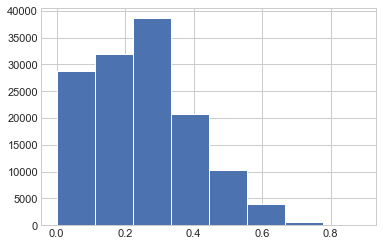

In [22]:
imp_data['rate'].hist(bins=8)
plt.show()

In [23]:
imp_data.loc[imp_data[imp_data['rate'] > 2/18].index, '2/18'] = 1
imp_data.loc[imp_data[imp_data['rate'] > 4/18].index, '4/18'] = 1
imp_data.loc[imp_data[imp_data['rate'] > 6/18].index, '6/18'] = 1
imp_data.loc[imp_data[imp_data['rate'] > 8/18].index, '8/18'] = 1

In [24]:
imp_data[['2/18','4/18','6/18','8/18']] = imp_data[['2/18','4/18','6/18','8/18']].fillna(0)

In [25]:
imp_data.MALOIM.replace(0.091,1, inplace=True)

In [26]:
imp_data[['MALOIM','2/18']].corr().iat[1,0]

0.3412900401752533

In [27]:
imp_data[['MALOIM','4/18']].corr().iat[1,0]

0.45297937986627057

In [28]:
imp_data[['MALOIM','6/18']].corr().iat[1,0]

0.37423609453754636

In [29]:
imp_data[['MALOIM','8/18']].corr().iat[1,0]

0.26265448934501684

In [30]:
imp_data[imp_data['rate'] > 4/18].shape[0]/imp_data.shape[0]

0.5505887936404354

In [31]:
imp_data[imp_data['MALOIM']==1].shape[0]/imp_data.shape[0]

0.31850473111262717

In [32]:
domains = vars_code[['domain_id', 'var_id']]
domains.query('domain_id == "domain_3"')['var_id'].to_list()

['I05_14', 'I05_29']

In [33]:
# расчет по доменам
imp_data['domain_1'] = imp_data['I10_07']
imp_data['domain_2'] = imp_data['I07_01']
imp_data['domain_3'] = imp_data[domains.query('domain_id == "domain_3"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_4'] = imp_data[domains.query('domain_id == "domain_4"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_5'] = imp_data[domains.query('domain_id == "domain_5"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_6'] = imp_data[domains.query('domain_id == "domain_6"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_7'] = imp_data[domains.query('domain_id == "domain_7"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_8'] = imp_data[domains.query('domain_id == "domain_8"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_9'] = imp_data[domains.query('domain_id == "domain_9"')['var_id'].to_list()].sum(axis=1)
imp_data['domain_10'] = imp_data['MALOIM']

In [34]:
imp_data.iloc[:,24::] = imp_data.iloc[:,24::].where(imp_data.iloc[:,24::] == 0,1)

In [35]:
imp_data['rate_domain'] = imp_data.iloc[:,24::].sum(axis=1)

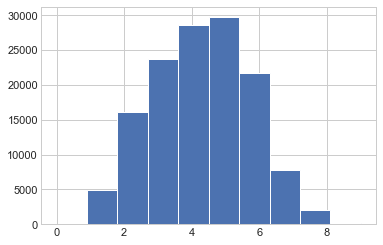

In [36]:
imp_data['rate_domain'].hist()

In [37]:
imp_data.loc[imp_data[imp_data['rate_domain'] >= 2].index, '2'] = 1
imp_data.loc[imp_data[imp_data['rate_domain'] >= 4].index, '4'] = 1
imp_data.loc[imp_data[imp_data['rate_domain'] >= 6].index, '6'] = 1
imp_data.loc[imp_data[imp_data['rate_domain'] >= 8].index, '8'] = 1

In [38]:
imp_data[['2','4','6','8']] = imp_data[['2','4','6','8']].fillna(0)

In [39]:
imp_data[['MALOIM','2']].corr().iat[1,0]

0.13241112019572784

In [40]:
imp_data[['MALOIM','4']].corr().iat[1,0]

0.41622832503319684

In [41]:
imp_data[['MALOIM','6']].corr().iat[1,0]

0.4811560504065104

In [42]:
imp_data[['MALOIM','8']].corr().iat[1,0]

0.18586361944315122

In [43]:
imp_data[imp_data['rate_domain'] >= 6].shape[0]/imp_data.shape[0]

0.23574733782220508

In [44]:
# с учетом взвешивания

# количество бедных в выборке
q = imp_data[imp_data['rate_domain'] >= 6].shape[0]

In [45]:
vars_code.domain_name.unique()

array(['Здоровье', 'Образование', 'Занятость', 'Базовые потребности',
       'Питание', 'Одежда и обувь', 'Общение и отдых',
       'Средства коммуникаций', 'Крупные покупки', 'Доход'], dtype=object)